
# Lab 1 - Image Processing - Segmentation & Registration




This TP / assignment aims to allow you to explore different segmentation and registration methods.

The data we'll use is from this github : https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md
Which are MRI images of brains.

Documents to submit :
* This notebook with your code and comments.
* A report (pdf format) to present the results of your different methods, how you implemented them, how they work, their differences, their strengths and their weaknesses. You can use LaTex or Typst for your report.

Only one student needs to submit for their group.


Student Name(s) (up to 4 for each group) :


1.   First Name, Last Name, student ID (matricule) :
2.   First Name, Last Name, student ID (matricule) :
3. ...
4.


### **Evaluation**

#### Segmentation (10 points)

Code : 3 points.

Report : 7 points. 3.5 points to present your results. 3.5 points to discuss your methods (how you implemented them, how they work, their differences, their strengths and their weaknesses).

#### Registration (10 points)

Code : 3 points.

Report : 7 points. 3.5 points to present your results. 3.5 points to discuss your methods (how you implemented them, how they work, their differences, their strengths and their weaknesses).

**Total : 20 points.**



### import libraries

In [1]:
import os
import tarfile
import urllib.request
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform

### Data preparation

Extracting example data...
Data ready in 'student_data/'. Files: image.nii.gz, seg.nii.gz


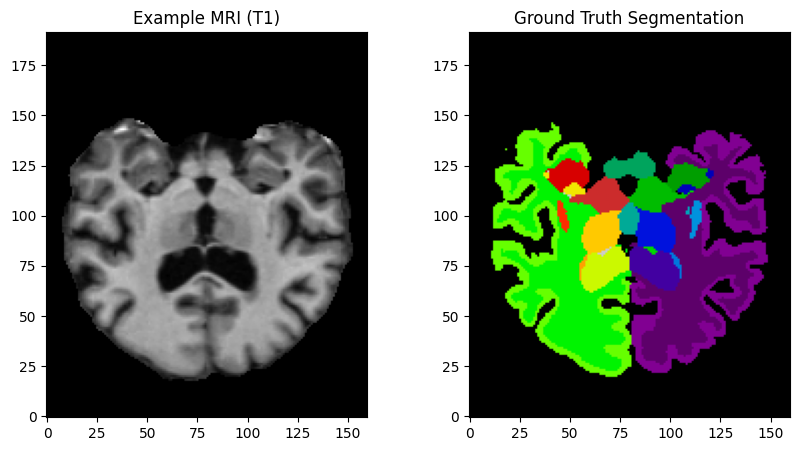

In [2]:

# 1. Download the lightweight 2D Neurite-OASIS dataset (approx 24MB)
url = "https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar"
tar_path = "neurite-oasis.2d.v1.0.tar"

if not os.path.exists(tar_path):
    print("Downloading dataset (24MB)...")
    urllib.request.urlretrieve(url, tar_path)
    print("Download complete.")

# 2. Extract one specific subject to serve as the example
# We will use subject 'OASIS_OAS1_0001_MR1'
subject_id = "OASIS_OAS1_0001_MR1"
output_dir = "student_data"
os.makedirs(output_dir, exist_ok=True)

print("Extracting example data...")
with tarfile.open(tar_path, "r") as tar:


    img_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_norm.nii.gz" in m.name][0]
    seg_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_seg24.nii.gz" in m.name][0]

    # Extract and rename for simplicity
    f_img = tar.extractfile(img_member)
    f_seg = tar.extractfile(seg_member)

    with open(os.path.join(output_dir, "image.nii.gz"), "wb") as out:
        out.write(f_img.read())
    with open(os.path.join(output_dir, "seg.nii.gz"), "wb") as out:
        out.write(f_seg.read())

print(f"Data ready in '{output_dir}/'. Files: image.nii.gz, seg.nii.gz")

# 3. Visualize the data
img = nib.load(os.path.join(output_dir, "image.nii.gz")).get_fdata().squeeze()
seg = nib.load(os.path.join(output_dir, "seg.nii.gz")).get_fdata().squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Example MRI (T1)")
plt.subplot(1, 2, 2)
plt.imshow(seg.T, cmap='nipy_spectral', origin='lower')
plt.title("Ground Truth Segmentation")
plt.show()

In [3]:
# If you want to get access to the other data

subject_ids_in_tar = set()

with tarfile.open(tar_path, "r") as tar:
    for member in tar.getmembers():
        if "slice_norm.nii.gz" in member.name:
            parts = member.name.split('/')
            if len(parts) > 0:
                subject_id = parts[0].split('_data')[0] # Get 'OASIS_OAS1_0001_MR1'
                subject_ids_in_tar.add(subject_id)

print(f"Total unique subjects found in the tar file: {len(subject_ids_in_tar)}")
print("Available Subject IDs:")
for sid in sorted(list(subject_ids_in_tar)): # Sort for consistent output
    print(f"- {sid}")


Total unique subjects found in the tar file: 414
Available Subject IDs:
- OASIS_OAS1_0001_MR1
- OASIS_OAS1_0002_MR1
- OASIS_OAS1_0003_MR1
- OASIS_OAS1_0004_MR1
- OASIS_OAS1_0005_MR1
- OASIS_OAS1_0006_MR1
- OASIS_OAS1_0007_MR1
- OASIS_OAS1_0009_MR1
- OASIS_OAS1_0010_MR1
- OASIS_OAS1_0011_MR1
- OASIS_OAS1_0012_MR1
- OASIS_OAS1_0013_MR1
- OASIS_OAS1_0014_MR1
- OASIS_OAS1_0015_MR1
- OASIS_OAS1_0016_MR1
- OASIS_OAS1_0017_MR1
- OASIS_OAS1_0018_MR1
- OASIS_OAS1_0019_MR1
- OASIS_OAS1_0020_MR1
- OASIS_OAS1_0021_MR1
- OASIS_OAS1_0022_MR1
- OASIS_OAS1_0023_MR1
- OASIS_OAS1_0025_MR1
- OASIS_OAS1_0026_MR1
- OASIS_OAS1_0027_MR1
- OASIS_OAS1_0028_MR1
- OASIS_OAS1_0029_MR1
- OASIS_OAS1_0030_MR1
- OASIS_OAS1_0031_MR1
- OASIS_OAS1_0032_MR1
- OASIS_OAS1_0033_MR1
- OASIS_OAS1_0034_MR1
- OASIS_OAS1_0035_MR1
- OASIS_OAS1_0037_MR1
- OASIS_OAS1_0038_MR1
- OASIS_OAS1_0039_MR1
- OASIS_OAS1_0040_MR1
- OASIS_OAS1_0041_MR1
- OASIS_OAS1_0042_MR1
- OASIS_OAS1_0043_MR1
- OASIS_OAS1_0044_MR1
- OASIS_OAS1_0045_MR1
- OA

In [4]:
# Done by me
# List all files in tar for 1 subject_id

subject_id = "OASIS_OAS1_0001_MR1"

with tarfile.open(tar_path, "r") as tar:
    subject_files = [m.name for m in tar.getmembers() if subject_id in m.name]

for f in subject_files:
    print(f)

OASIS_OAS1_0001_MR1/slice_norm.nii.gz
OASIS_OAS1_0001_MR1/slice_orig.nii.gz
OASIS_OAS1_0001_MR1/slice_seg24.nii.gz
OASIS_OAS1_0001_MR1/slice_seg4.nii.gz


# Segmentation

This code provides you a segmentation with 4 classes.

Data ready in 'student_data/'. Files: image.nii.gz, seg.nii.gz


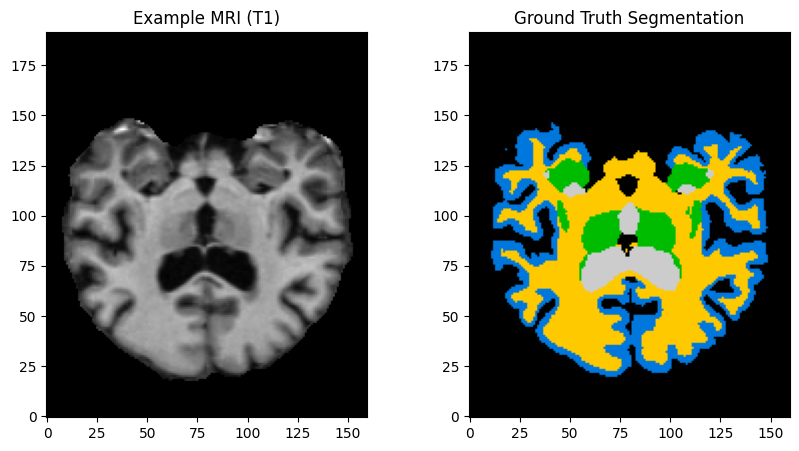

In [5]:
subject_id = "OASIS_OAS1_0001_MR1"
output_dir = "student_data"
os.makedirs(output_dir, exist_ok=True)

with tarfile.open(tar_path, "r") as tar:
    img_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_norm.nii.gz" in m.name][0]
    seg_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_seg4.nii.gz" in m.name][0]

    # Extract and rename for simplicity
    f_img = tar.extractfile(img_member)
    f_seg = tar.extractfile(seg_member)

    with open(os.path.join(output_dir, "image.nii.gz"), "wb") as out:
        out.write(f_img.read())
    with open(os.path.join(output_dir, "seg.nii.gz"), "wb") as out:
        out.write(f_seg.read())

print(f"Data ready in '{output_dir}/'. Files: image.nii.gz, seg.nii.gz")

# 3. Visualize the data
img = nib.load(os.path.join(output_dir, "image.nii.gz")).get_fdata().squeeze()
seg = nib.load(os.path.join(output_dir, "seg.nii.gz")).get_fdata().squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Example MRI (T1)")
plt.subplot(1, 2, 2)
plt.imshow(seg.T, cmap='nipy_spectral', origin='lower')
plt.title("Ground Truth Segmentation")
plt.show()

There are plenty of classes for the segmentation. You can do a simpler segmentation where you have 4 labels (instead of 24). It's up to you.

## Methods

You have to do a segmentation of the previous image showed.
You need to use 2 different methods. Explain the differences between these methods.

### List of possible methods (you can use other methods!) :

#### Multi-Otsu Thresholding

* [Reference](https://ieeexplore.ieee.org/document/4310076)

* [Python implementation](https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_multiotsu.html)
####   Gaussian Mixture Models (GMM)

* [Reference](https://towardsdatascience.com/gaussian-mixture-models-gmms-from-theory-to-implementation-4406c7fe9847/)

* [Python implementation](https://scikit-learn.org/stable/modules/mixture.html)
####   U-Net (Deep Learning)
* [Reference](https://arxiv.org/abs/1505.04597)
* Python implementation : use Pytorch

#### Random Walker
* [Reference](https://ieeexplore.ieee.org/document/1704833)
* [Python implementation](https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_random_walker_segmentation.html)



### Method 1

Data ready in 'student_data/otsu/'. Files: OASIS_OAS1_0001_MR1_image.nii.gz, OASIS_OAS1_0001_MR1_seg.nii.gz


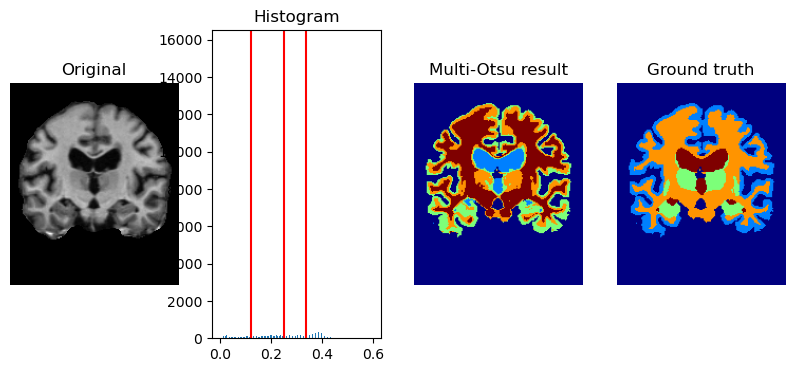

In [6]:
#Multi otsu

from skimage.filters import threshold_multiotsu


# Retrieve img subject

subject_id = "OASIS_OAS1_0001_MR1"
output_dir = "student_data/otsu"
os.makedirs(output_dir, exist_ok=True)

with tarfile.open(tar_path, "r") as tar:
    img_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_norm.nii.gz" in m.name][0]
    seg_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_seg4.nii.gz" in m.name][0]

    # Extract and rename for simplicity
    f_img = tar.extractfile(img_member)
    f_seg = tar.extractfile(seg_member)

    with open(os.path.join(output_dir, subject_id + "_image.nii.gz"), "wb") as out:
        out.write(f_img.read())
    with open(os.path.join(output_dir, subject_id + "_seg.nii.gz"), "wb") as out:
        out.write(f_seg.read())

print(f"Data ready in '{output_dir}/'. Files: {subject_id}_image.nii.gz, {subject_id}_seg.nii.gz")

# Apply Multi Otsu
img = nib.load(os.path.join(output_dir, subject_id + "_image.nii.gz")).get_fdata().squeeze()
seg = nib.load(os.path.join(output_dir, subject_id + "_seg.nii.gz")).get_fdata().squeeze()

#Mask BG
mask = seg > 0
pixels = img[mask]

thresholds = threshold_multiotsu(pixels, 4)

seg_mo = np.zeros_like(img, dtype=np.int32)
seg_mo[mask] = np.digitize(img[mask], bins=thresholds) + 1


fig, ax = plt.subplots(1, 4, figsize=(10, 4))

ax[0].imshow(img.T, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(img.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

ax[2].imshow(seg_mo.T, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

ax[3].imshow(seg.T, cmap='jet')
ax[3].set_title('Ground truth')
ax[3].axis('off')


plt.show()

In [7]:
def dice_score_multiclass(pred, target, num_classes, eps=1e-6, ignore_background=True):
    dices = []

    start_class = 1 if ignore_background else 0

    for c in range(start_class, num_classes):
        pred_c = (pred == c)
        target_c = (target == c)

        intersection = np.logical_and(pred_c, target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union == 0:
            dice = 1.0   # both empty → perfect agreement
        else:
            dice = (2 * intersection + eps) / (union + eps)

        dices.append(dice)

    return np.mean(dices), dices


In [8]:
subject_ids_in_tar = set()
output_dir = "student_data"

with tarfile.open(tar_path, "r") as tar:
    for member in tar.getmembers():
        if "slice_norm.nii.gz" in member.name:
            parts = member.name.split('/')
            if len(parts) > 0:
                subject_id = parts[0].split('_data')[0] # Get 'OASIS_OAS1_0001_MR1'
                subject_ids_in_tar.add(subject_id)

dice_scores = []

for subject_id in sorted(list(subject_ids_in_tar)): # Sort for consistent output
    # Apply Multi Otsu
    img = nib.load(os.path.join(output_dir, subject_id + "_image.nii.gz")).get_fdata().squeeze()
    seg = nib.load(os.path.join(output_dir, subject_id + "_seg4.nii.gz")).get_fdata().squeeze()

    #Mask BG
    mask = seg > 0
    pixels = img[mask]

    thresholds = threshold_multiotsu(pixels, 4)

    seg_mo = np.zeros_like(img, dtype=np.int32)
    seg_mo[mask] = np.digitize(img[mask], bins=thresholds) + 1

    dice = dice_score_multiclass(seg_mo, seg, 5)[0] # 5 classes including bg (bg ignored in function)
    dice_scores.append(dice)

dice_mean = np.mean(dice_scores)
print(f"Average Dice score = {dice_mean}")



Average Dice score = 0.16513761664956048


### Method 2

In [11]:
# If you want to get access to the other data

subject_ids_in_tar = set()

with tarfile.open(tar_path, "r") as tar:
    for member in tar.getmembers():
        if "slice_norm.nii.gz" in member.name:
            parts = member.name.split('/')
            if len(parts) > 0:
                subject_id = parts[0].split('_data')[0] 
                subject_ids_in_tar.add(subject_id)



for subject_id in subject_ids_in_tar:
    output_dir = "student_data"
    os.makedirs(output_dir, exist_ok=True)

    with tarfile.open(tar_path, "r") as tar:
        img_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_norm.nii.gz" in m.name][0]
        seg_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_seg4.nii.gz" in m.name][0]

        # Extract and rename for simplicity
        f_img = tar.extractfile(img_member)
        f_seg = tar.extractfile(seg_member)

        with open(os.path.join(output_dir, subject_id + "_image.nii.gz"), "wb") as out:
            out.write(f_img.read())
        with open(os.path.join(output_dir, subject_id + "_seg4.nii.gz"), "wb") as out:
            out.write(f_seg.read())

    print(f"Data ready in '{output_dir}/'. Files: {subject_id}_image.nii.gz, {subject_id}_seg4.nii.gz")



Data ready in 'student_data/'. Files: OASIS_OAS1_0170_MR1_image.nii.gz, OASIS_OAS1_0170_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0425_MR1_image.nii.gz, OASIS_OAS1_0425_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0098_MR1_image.nii.gz, OASIS_OAS1_0098_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0314_MR1_image.nii.gz, OASIS_OAS1_0314_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0029_MR1_image.nii.gz, OASIS_OAS1_0029_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0020_MR1_image.nii.gz, OASIS_OAS1_0020_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0353_MR1_image.nii.gz, OASIS_OAS1_0353_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0209_MR1_image.nii.gz, OASIS_OAS1_0209_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0447_MR1_image.nii.gz, OASIS_OAS1_0447_MR1_seg4.nii.gz
Data ready in 'student_data/'. Files: OASIS_OAS1_0183_MR1_image.

In [7]:
import sys, torch, numpy, matplotlib, nibabel, skimage
print(sys.executable)
print(torch.__version__)
print(torch.cuda.is_available())
print(numpy.__version__)
print(matplotlib.__version__)
print(nibabel.__version__)
print(skimage.__version__)


c:\Users\ronal\miniconda3\envs\gbm6953\python.exe
2.5.1
False
2.0.1
3.10.8
5.3.2
0.25.2


In [ ]:
# U-net

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

class DoubleConv(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),

            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)
    
class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)       # (B, 64, 160, 192)
        p1 = self.pool1(e1)    # (B, 64, 80, 96)

        e2 = self.enc2(p1)     # (B, 128, 80, 96)
        p2 = self.pool2(e2)    # (B, 128, 40, 48)

        e3 = self.enc3(p2)     # (B, 256, 40, 48)
        p3 = self.pool3(e3)    # (B, 256, 20, 24)

        e4 = self.enc4(p3)     # (B, 512, 20, 24)
        p4 = self.pool4(e4)    # (B, 512, 10, 12)

        # Bottleneck
        b = self.bottleneck(p4)  # (B, 1024, 10, 12)

        # Decoder
        u4 = self.up4(b)                 # (B, 512, 20, 24)
        d4 = self.dec4(torch.cat([u4, e4], dim=1))

        u3 = self.up3(d4)                # (B, 256, 40, 48)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))

        u2 = self.up2(d3)                # (B, 128, 80, 96)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)                # (B, 64, 160, 192)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        out = self.outconv(d1)           # (B, 5, 160, 192)

        return out


class MRIDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): path to folder containing MRI and seg files
            transform (callable, optional): optional transform on image and mask
        """
        self.data_dir = data_dir
        self.transform = transform

        # collect all image files
        self.image_files = sorted([f for f in os.listdir(data_dir) if f.endswith("_image.nii.gz")])
        self.mask_files  = [f.replace("_image.nii.gz", "_seg4.nii.gz") for f in self.image_files]

        # every image must have a corresponding mask
        for m in self.mask_files:
            if not os.path.exists(os.path.join(data_dir, m)):
                raise FileNotFoundError(f"Missing mask for {m}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        mask_path = os.path.join(self.data_dir, self.mask_files[idx])

        # load MRI and mask
        img = nib.load(img_path).get_fdata().squeeze()
        mask = nib.load(mask_path).get_fdata().squeeze()

        # ensure correct types
        img = np.array(img, dtype=np.float32)
        mask = np.array(mask, dtype=np.int64)

        # add channel dimension to image
        img = np.expand_dims(img, axis=0)

        # optional transforms
        if self.transform:
            img, mask = self.transform(img, mask)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

    


: 

In [9]:
data_dir = "student_data"  # folder containing all *_image.nii.gz and *_seg4.nii.gz

dataset = MRIDataset(data_dir)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)


batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)

            total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


def dice_score(pred, target, num_classes=5, eps=1e-6):
    """
    pred: logits from model, shape (B, C, H, W)
    target: ground truth labels, shape (B, H, W)
    """

    pred = torch.argmax(pred, dim=1)  # (B, H, W)

    dices = []

    for c in range(1, num_classes):  # ignore background = 0
        pred_c = (pred == c).float()       # (B, H, W)
        target_c = (target == c).float()   # (B, H, W)

        # per-image Dice
        intersection = (pred_c * target_c).sum(dim=(1, 2))   # (B,)
        union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # (B,)

        dice = (2 * intersection + eps) / (union + eps)  # (B,)
        dices.append(dice)

    dices = torch.stack(dices, dim=1)   # (B, C-1)
    return dices.mean().item()

In [ ]:
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_classes=5).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


data_dir = "student_data"
full_dataset = MRIDataset(data_dir)

# 80/10/10 split
# take 10% for test

train_val_idx, test_idx = train_test_split(
    range(len(full_dataset)),
    test_size=0.1,          # 10% test
    random_state=42,
    shuffle=True
)

train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.1111,       # 10/90 = 11.11% of remaining
    random_state=42,
    shuffle=True
)



train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset   = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

# DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



num_epochs = 30
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss = evaluate(model, val_loader, criterion, device)

    # Dice on validation
    model.eval()
    
    total_dice = 0.0
    total_samples = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)
            batch_dice = dice_score(outputs, masks)

            total_dice += batch_dice * imgs.size(0)
            total_samples += imgs.size(0)

    mean_dice = total_dice / total_samples

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Dice: {mean_dice:.4f}"
    )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet.pth")




Epoch 01 | Train Loss: 0.0515 | Val Loss: 0.0587 | Val Dice: 0.9468
Epoch 02 | Train Loss: 0.0496 | Val Loss: 0.0537 | Val Dice: 0.9502
Epoch 03 | Train Loss: 0.0486 | Val Loss: 0.0550 | Val Dice: 0.9494
Epoch 04 | Train Loss: 0.0482 | Val Loss: 0.0556 | Val Dice: 0.9472
Epoch 05 | Train Loss: 0.0480 | Val Loss: 0.0541 | Val Dice: 0.9502
Epoch 06 | Train Loss: 0.0474 | Val Loss: 0.0533 | Val Dice: 0.9505
Epoch 07 | Train Loss: 0.0473 | Val Loss: 0.0537 | Val Dice: 0.9502
Epoch 08 | Train Loss: 0.0472 | Val Loss: 0.0535 | Val Dice: 0.9500
Epoch 09 | Train Loss: 0.0466 | Val Loss: 0.0577 | Val Dice: 0.9482
Epoch 10 | Train Loss: 0.0462 | Val Loss: 0.0576 | Val Dice: 0.9480
Epoch 11 | Train Loss: 0.0455 | Val Loss: 0.0633 | Val Dice: 0.9449
Epoch 12 | Train Loss: 0.0463 | Val Loss: 0.0533 | Val Dice: 0.9506
Epoch 13 | Train Loss: 0.0452 | Val Loss: 0.0539 | Val Dice: 0.9506
Epoch 14 | Train Loss: 0.0453 | Val Loss: 0.0548 | Val Dice: 0.9502
Epoch 15 | Train Loss: 0.0445 | Val Loss: 0.0534

RuntimeError: Numpy is not available

C:\Users\ronal\AppData\Local\Temp\ipykernel_648\2519265534.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_unet.pth", map_location

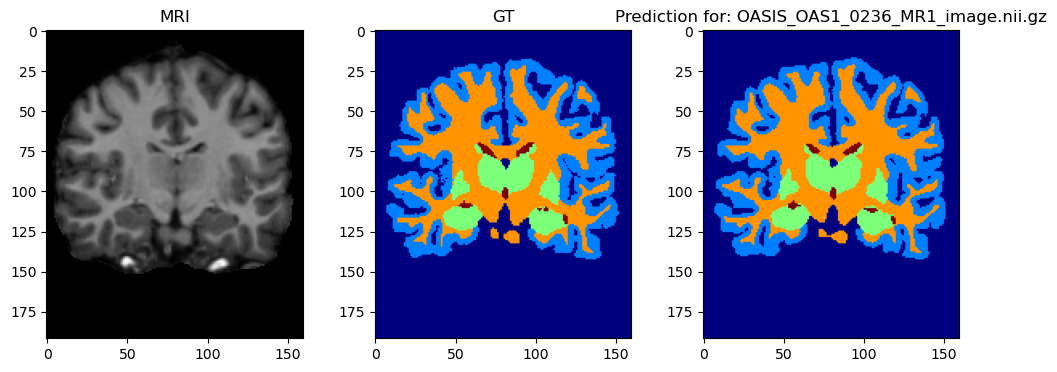

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_classes=5).to(device)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))
model.eval()

with torch.no_grad():
    img, mask = test_dataset[0]
    logits = model(img.unsqueeze(0).to(device))
    pred = torch.argmax(logits, dim=1).cpu().squeeze().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img.T.squeeze(), cmap="gray"); plt.title("MRI")
plt.subplot(1,3,2); plt.imshow(mask.T, cmap="jet", vmin=0, vmax=4); plt.title("GT")
plt.subplot(1,3,3); plt.imshow(pred.T, cmap="jet", vmin=0, vmax=4); plt.title(f"Prediction for: {dataset.image_files[test_dataset.indices[0]]}")
plt.show()




### Evaluation and results
Present your results and evaluate them with different metrics (for both methods). You need to use Dice coefficient and you can use other metrics (such as IoU) that you think are relevant. You can present other segmented images from 2D Neurite-OASIS dataset.

## Registration




This section focuses on image registration.  
The next cell provides a fixed image $I_{\text{fixed}}$ and a moving (floating) image $I_{\text{moving}}$.

You are required to implement two different registration methods in order to estimate a transformation $T$ such that:
$$
I_{\text{moving}} \circ T \approx I_{\text{fixed}}.
$$


This code creates a rigid transformation.

Generating Synthetic Data: Rotation=-3.76°, Shift=(0.90, 0.46)


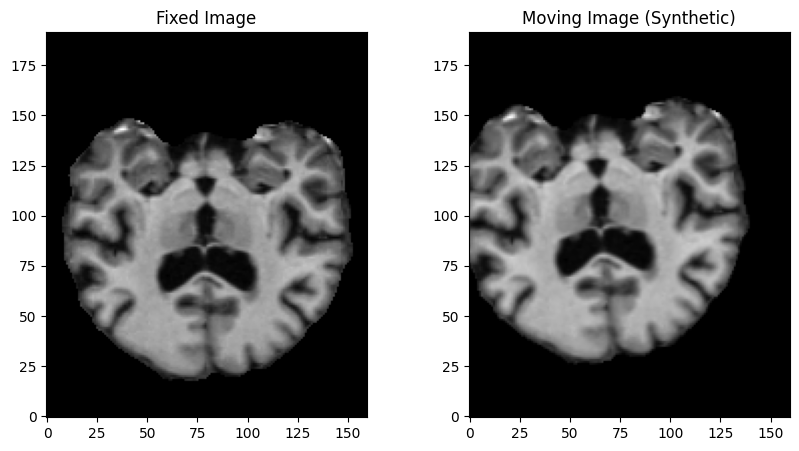

In [6]:
# rigid transformation
np.random.seed(42)
def create_synthetic_moving_data(fixed_img, fixed_seg, rotation_range=15, shift_range=1):
    """
    Creates a 'Moving' image by applying a random affine transform
    (rotation + translation) to the Fixed image.
    """
    # 1. Generate random parameters
    angle_deg = np.random.uniform(-rotation_range, rotation_range)
    shift_y = np.random.uniform(-shift_range, shift_range)
    shift_x = np.random.uniform(-shift_range, shift_range)

    print(f"Generating Synthetic Data: Rotation={angle_deg:.2f}°, Shift=({shift_y:.2f}, {shift_x:.2f})")

    # 2. Define the Affine Matrix (Inverse mapping is usually required for scipy)
    # Convert to radians
    theta = np.radians(angle_deg)
    c, s = np.cos(theta), np.sin(theta)

    # Rotation matrix (centered usually requires offset handling,
    # but for simple tasks, direct matrix application is often sufficient
    # if we ignore center-of-rotation artifacts or handle them via 'offset')

    # To rotate around center, we often shift center to origin -> rotate -> shift back.
    # Here we simplify:
    center = np.array(fixed_img.shape) / 2.0
    rotation_mat = np.array([[c, -s], [s, c]])
    offset = center - center.dot(rotation_mat) + np.array([shift_y, shift_x])

    # 3. Apply transformation
    # We use spline interpolation (order=1) for the image
    moving_img = affine_transform(
        fixed_img,
        matrix=rotation_mat,
        offset=offset,
        order=1,
        mode='constant'
    )

    # We use nearest neighbor (order=0) for the segmentation (labels must remain integers)
    moving_seg = affine_transform(
        fixed_seg,
        matrix=rotation_mat,
        offset=offset,
        order=0,
        mode='constant'
    )

    return moving_img, moving_seg

# --- Usage Example ---
# Create the moving image
moving_img, moving_seg = create_synthetic_moving_data(img, seg)

# Visualize Fixed vs Moving
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Fixed Image")
plt.subplot(1, 2, 2)
plt.imshow(moving_img.T, cmap='gray', origin='lower')
plt.title("Moving Image (Synthetic)")
plt.show()

Add a non-rigid transformation to the moving image.

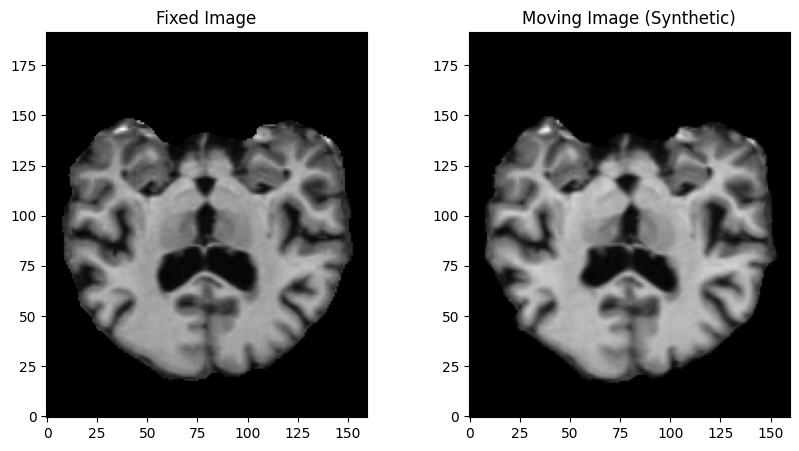

In [7]:
from scipy.ndimage import map_coordinates,gaussian_filter

def non_rigid_trans(fixed_img, fixed_seg, alpha=20, sigma=5):

    """
    Apply elastic transformation

    alpha: magnitude of deformation
    sigma : smoothness. larger sigma = smoother
    20px max displacement, smooth over 5px

    """

    H, W = fixed_img.shape

    dx = gaussian_filter(np.random.randn(H, W), sigma=sigma) * alpha
    dy = gaussian_filter(np.random.randn(H, W), sigma=sigma) * alpha

    H, W = fixed_img.shape
    y, x = np.meshgrid(
    np.arange(H),
    np.arange(W),
    indexing='ij'
    )

    coords = [y + dy, x + dx]

    moving_img = map_coordinates(
        fixed_img,
        coords,
        order=1,
        mode='constant'
    )

    moving_seg = map_coordinates(
        fixed_seg,
        coords,
        order=0,
        mode='constant'
    )
    
    return moving_img, moving_seg


# --- Usage Example ---
# Create the moving image
moving_img, moving_seg = non_rigid_trans(img, seg, 20, 5)

# Visualize Fixed vs Moving
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Fixed Image")
plt.subplot(1, 2, 2)
plt.imshow(moving_img.T, cmap='gray', origin='lower')
plt.title("Moving Image (Synthetic)")
plt.show()

Now, implement 2 different methods of registration

### List of possible methods (you can use other methods!) :

#### Phase Correlation / Fourier Shift Theorem
* [Reference](https://en.wikipedia.org/wiki/Phase_correlation)
* [Python implementation](https://scikit-image.org/docs/stable/api/skimage.registration.html)

#### Mutual Information Maximization
* [Reference](https://link.springer.com/article/10.1023/A:1007958904918)
* [Python implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) (requires coding the MI loss function)

#### VoxelMorph
* [Reference](https://arxiv.org/abs/1809.05231)
* [Python implementation](https://github.com/voxelmorph/voxelmorph)

#### B-Spline Free Form Deformation
* [Reference](https://ieeexplore.ieee.org/document/796284)
* [Python implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html)



### Method 1

Generating Synthetic Data: Rotation=-10.85°, Shift=(-0.28, -0.05)


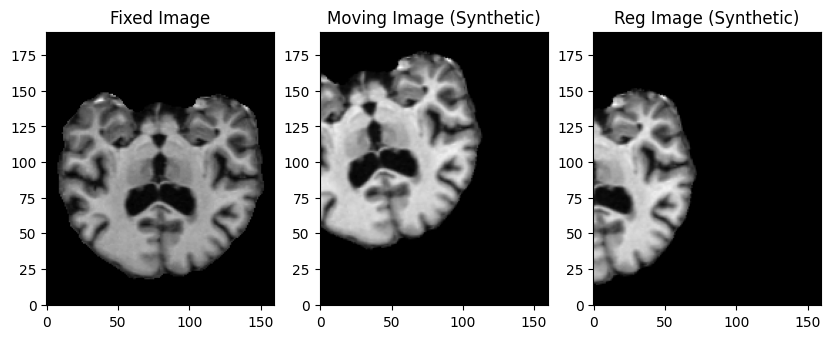

In [8]:
#Phase correlation

from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as ndi_shift
import tarfile
#phase_cross_correlation only estimates a global translation between the 2 images.


subject_ids_in_tar = []
output_dir = "student_data"
tar_path = "neurite-oasis.2d.v1.0.tar"

with tarfile.open(tar_path, "r") as tar:
    for member in tar.getmembers():
        if "slice_norm.nii.gz" in member.name:
            parts = member.name.split('/')
            if len(parts) > 0:
                subject_id = parts[0].split('_data')[0] # Get 'OASIS_OAS1_0001_MR1'
                subject_ids_in_tar.append(subject_id)

subject_id = subject_ids_in_tar[0]

img = nib.load(os.path.join(output_dir, subject_id + "_image.nii.gz")).get_fdata().squeeze()
seg = nib.load(os.path.join(output_dir, subject_id + "_seg4.nii.gz")).get_fdata().squeeze()

mov_img, moving_seg = create_synthetic_moving_data(img,seg)

shift_vector, error, _ = phase_cross_correlation(img,mov_img)

reg_img = ndi_shift(mov_img, shift_vector)
# Visualize Fixed vs Moving
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Fixed Image")
plt.subplot(1, 3, 2)
plt.imshow(mov_img.T, cmap='gray', origin='lower')
plt.title("Moving Image (Synthetic)")
plt.subplot(1, 3, 3)
plt.imshow(reg_img.T, cmap='gray', origin='lower')
plt.title("Reg Image (Synthetic)")
plt.show()

In [19]:
print(img.shape)

(160, 192)


### Method 2

In [9]:
def minmaxnorm(img):
    img_min, img_max = img.min(), img.max()
    if img_max > img_min:
        return (img-img_min)/(img_max-img_min)
    return (img)

In [23]:
#Voxel Morph
import os 
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split

subject_ids_in_tar = []
output_dir = "student_data"

with tarfile.open(tar_path, "r") as tar:
    for member in tar.getmembers():
        if "slice_norm.nii.gz" in member.name:
            parts = member.name.split('/')
            if len(parts) > 0:
                subject_id = parts[0].split('_data')[0] # Get 'OASIS_OAS1_0001_MR1'
                subject_ids_in_tar.append(subject_id)

for subject_id in subject_ids_in_tar:

    img = nib.load(os.path.join(output_dir, subject_id + "_image.nii.gz")).get_fdata().squeeze()
    #seg = nib.load(os.path.join(output_dir, subject_id + "_seg4.nii.gz")).get_fdata().squeeze()

    n_img = minmaxnorm(img)
    #n_seg = minmaxnorm(seg)

    np.savez(os.path.join(output_dir, f"{subject_id}_image.npz"), vol=n_img.astype(np.float32))
    #np.savez(os.path.join(output_dir, f"{subject_id}_seg4.npz"), vol=n_img.astype(np.float32))
    for i in range(3):  # 3 transforms/subject
        moving, _ = non_rigid_trans(n_img, n_img)  # B-spline etc.
        np.savez(os.path.join(output_dir, f"{subject_id}_moving_{i}.npz"), vol=moving.astype(np.float32))
        


npz_dir = "student_data"
all_npz = [f for f in os.listdir(npz_dir) if f.endswith('.npz')]

# 80/10/10 stratified (preserves orig/synthetic ratio)
train_val, test = train_test_split(all_npz, test_size=0.1, random_state=42)
train_files, val_files = train_test_split(train_val, test_size=0.111, random_state=42)  # 10% of 90%

# Save lists CORRECTLY
with open(os.path.join(npz_dir, 'train.txt'), 'w') as file_handle:
    for filename in train_files:
        file_handle.write(filename + '\n')
with open(os.path.join(npz_dir, 'val.txt'), 'w') as file_handle:
    for filename in val_files:
        file_handle.write(filename + '\n')
with open(os.path.join(npz_dir, 'test.txt'), 'w') as file_handle:
    for filename in test:
        file_handle.write(filename + '\n')

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test)}")




Train: 1324, Val: 166, Test: 166


In [1]:
"""
Anaconda prompt:

conda activate voxelmorph
cd Desktop\Poly\2026H\voxelmorph
git clone https://github.com/voxelmorph/voxelmorph.git
cd voxelmorph/docs
In setup.py, specify numpy version 1.26.4
pip install -r requirements.txt
cd ..
pip install -e .
pip install tensorflow==2.15.0
pip install ipykernel if needed
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
"""

# import voxelmorph
import sys 
sys.path.append('voxelmorph')
import voxelmorph as vxm
import torch
print(f"Torch: {torch.__version__}")  # Match training version


Torch: 2.5.1+cu121


In [ ]:
import os
import torch
import numpy as np
import voxelmorph as vxm

# PyTorch backend
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'

def register_2d(moving_file, fixed_file, model_file, moved_file=None, warp_file=None, gpu=0):

    """
    2D VoxelMorph registration (your trained model!)
    
    Args:
        moving_file: str, source NPZ/NIfTI
        fixed_file: str, target NPZ/NIfTI
        model_file: str, your student_data_best.pt
        moved_file: str, warped.nii.gz output
        warp_file: str, flow.nii.gz output (opt)
        gpu: int or None for CPU
    """


    device = 'cuda' if (gpu is not None and torch.cuda.is_available()) else 'cpu'
    print(f"Using {device}")
    
    # Load data
    moving = vxm.py.utils.load_volfile(moving_file, add_batch_axis=True)
    fixed, fixed_affine = vxm.py.utils.load_volfile(fixed_file, add_batch_axis=True, ret_affine=True)
    
    # Model + FIXED LOAD
    model = vxm.nn.models.VxmPairwise(ndim=2, source_channels=1, target_channels=1, 
                                     nb_features=[32,32,32], integration_steps=0).to(device)
    checkpoint = torch.load(model_file, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint)  # Direct state_dict
    model.eval()
    
    # Register (same)
    input_moving = torch.from_numpy(moving).unsqueeze(1).to(device).float()
    input_fixed = torch.from_numpy(fixed).unsqueeze(1).to(device).float()
    
    with torch.no_grad():
        disp, moved = model(input_moving, input_fixed, return_warped_source=True, 
                           return_field_type='displacement')
    
    # Save + return (same)
    moved_np = moved.detach().cpu().numpy().squeeze()
    if moved_file: vxm.py.utils.save_volfile(moved_np, moved_file, fixed_affine)
    if warp_file: 
        warp_np = disp.detach().cpu().numpy().squeeze()
        vxm.py.utils.save_volfile(warp_np, warp_file, fixed_affine)
    
    print(f"Done! {moved_file}")
    return moved_np, disp.detach().cpu().numpy().squeeze()


# USAGE
moving, disp = register_2d(
    moving_file='student_data/OASIS_OAS1_0001_MR1_moving_0.npz',
    fixed_file='student_data/OASIS_OAS1_0001_MR1_image.npz',
    model_file='student_data_best.pt',
    moved_file='warped.nii.gz',
    warp_file='flow.nii.gz',
    gpu=0
)


Using cuda
Done! warped.nii.gz


In [14]:
def dice_jac_score(warped, flow, fixed):
    # Dice (image similarity)
    pred_bin = (warped > warped.mean()).astype(float)
    target_bin = (fixed > fixed.mean()).astype(float)
    dice = (2 * np.sum(pred_bin * target_bin) + 1e-6) / (np.sum(pred_bin) + np.sum(target_bin) + 1e-6)
    
    # Jacobian (manual finite difference)
    jac_x = np.gradient(flow[:,:,0], axis=1)  # ∂u/∂x
    jac_y = np.gradient(flow[:,:,1], axis=0)  # ∂v/∂y  
    jac_det = (1 + jac_x) * (1 + jac_y) - np.gradient(flow[:,:,1], axis=1) * np.gradient(flow[:,:,0], axis=0)
    
    jac_valid = np.mean(jac_det > 0)
    jac_mean = np.mean(jac_det)
    
    return dice, jac_valid, jac_mean

In [9]:

pairs = [
    ('student_data/OASIS_OAS1_0001_MR1_moving_0.npz', 'student_data/OASIS_OAS1_0001_MR1_image.npz'),
    ('student_data/OASIS_OAS1_0002_MR1_moving_1.npz', 'student_data/OASIS_OAS1_0002_MR1_image.npz'),
    # ... add more pairs
]

results = []
for i, (moving_file, fixed_file) in enumerate(pairs):
    print(f"Registering {i+1}/{len(pairs)}: {os.path.basename(moving_file)}")
    
    warped, flow = register_2d(
        moving_file=moving_file,
        fixed_file=fixed_file,
        model_file='student_data_best.pt',
        moved_file=f'warped_{i}.nii.gz',
        warp_file=f'flow_{i}.nii.gz',
        gpu=0
    )
    
    results.append({
        'moving': moving_file, 
        'fixed': fixed_file,
        'warped': warped,
        'flow': flow
    })
    print(f"{i+1} done!\n")

print(f"Batch complete! {len(results)} registrations.")


Registering 1/2: OASIS_OAS1_0001_MR1_moving_0.npz
Using cuda
Done! warped_0.nii.gz
1 done!

Registering 2/2: OASIS_OAS1_0002_MR1_moving_1.npz
Using cuda
Done! warped_1.nii.gz
2 done!

Batch complete! 2 registrations.


In [15]:
# EVALUATE ALL
dice_scores, jac_valid, jac_mean = [], [], []
for i, result in enumerate(results):
    moving_file = result['moving']
    fixed_file = result['fixed']
    
    # Load fixed data
    fixed_data = np.load(f"{fixed_file}")['vol'].squeeze()
    
    # Score
    dice, jvalid, jmean = dice_jac_score(result['warped'], result['flow'], fixed_data)
    
    dice_scores.append(dice)
    jac_valid.append(jvalid)
    jac_mean.append(jmean)
    
    print(f"Pair {i+1}: Dice={dice:.4f}, JacValid={jvalid:.1%}, JacMean={jmean:.3f}")

# SUMMARY
print("\n" + "="*50)
print(f"MEAN: Dice={np.mean(dice_scores):.4f}±{np.std(dice_scores):.4f}")
print(f"     JacValid={np.mean(jac_valid):.1%}±{np.std(jac_valid):.4f}")
print(f"     JacMean={np.mean(jac_mean):.3f}±{np.std(jac_mean):.3f}")
print("="*50)


Pair 1: Dice=0.9768, JacValid=100.0%, JacMean=1.157
Pair 2: Dice=0.9833, JacValid=100.0%, JacMean=1.118

MEAN: Dice=0.9801±0.0032
     JacValid=100.0%±0.0000
     JacMean=1.138±0.020


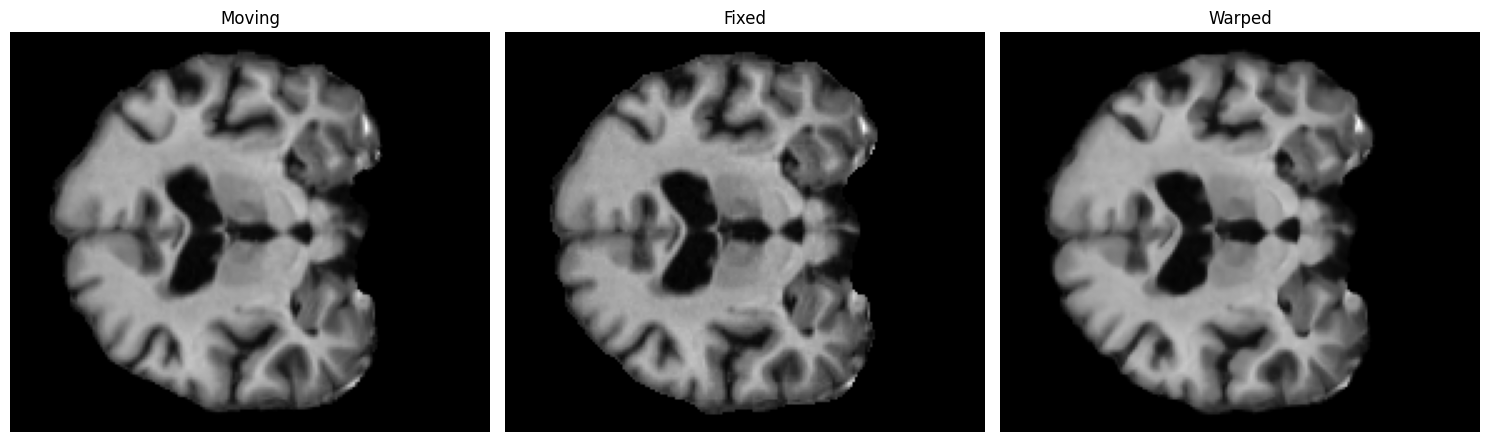

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import voxelmorph as vxm  # Full import

# Direct NPZ load (no utils needed)
moving = np.load('student_data/OASIS_OAS1_0001_MR1_moving_0.npz')['vol'].squeeze()
fixed = np.load('student_data/OASIS_OAS1_0001_MR1_image.npz')['vol'].squeeze()
warped = vxm.py.utils.load_volfile('warped.nii.gz').squeeze()

fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax, data, title in zip(axes, [moving, fixed, warped], 
                          ['Moving', 'Fixed', 'Warped']):
    ax.imshow(data, cmap='gray')
    ax.set_title(title); ax.axis('off')
plt.tight_layout(); plt.savefig('comparison.png', dpi=150); plt.show()


Present the results and evaluate them using multiple metrics for both methods. Report the Dice coefficient and, where appropriate, include other relevant measures (for example, Intersection over Union — IoU). Additionally, you may present other registration examples to illustrate the effectiveness of your methods.